### Assignment 1 - Point to Point communications


by Généreux M. AKOTENOU

In [2]:
"""
En exécutant tout ce notebook, le dossier 'genereux_akotenou1' sera créé et il contiendra les fichiers Python de chaque exercice.
On pourra par la suite utiliser la commande suivante pour exécuter chaque script et voir les sorties :

$ mpirun -n <number> python3 <filename.py>
""" 
import os
directory = 'genereux_akotenou1'
if not os.path.exists(directory):
    os.makedirs(directory)

* EXO1

In [6]:
%%file genereux_akotenou1/exo1.py

from mpi4py import MPI
COMM = MPI.COMM_WORLD 
SIZE = COMM.Get_size() 
RANK = COMM.Get_rank()

if RANK==0:
    print("Hello World. RANK: {RANK} among {SIZE} PROCESS".format(RANK = RANK, SIZE = SIZE))

Overwriting genereux_akotenou1/exo1.py


In [16]:
# OUTPUT
# % mpirun -n 4 python3 exo1.py
#
# Hello World. RANK: 0 among 4 PROCESS

* EXO2

In [18]:
%%file genereux_akotenou1/exo2.py

from mpi4py import MPI
COMM = MPI.COMM_WORLD 
SIZE = COMM.Get_size() 
RANK = COMM.Get_rank()

assert SIZE > 1, "The number of process should be great than 1"

data = 0
while True:
    # Collect Data and broacast
    if RANK == 0:
        data = int(input(""))
        if data < 0:
            COMM.Abort()
        for process in range(SIZE):
            COMM.send(data, dest=process)
    
    # Print received data
    receiveBuff = COMM.recv(source=0)
    print(f"Process {RANK} got {receiveBuff}")

Overwriting genereux_akotenou1/exo2.py


In [ ]:
# OUTPUT
# % mpirun -n 3 python3 exo2.py
#
# 10
# Process 0 got 10
# Process 2 got 10
# Process 1 got 10
# 2
# Process 0 got 2
# Process 1 got 2
# Process 2 got 2
# -1
# --------------------------------------------------------------------------
# MPI_ABORT was invoked on rank 0 in communicator MPI_COMM_WORLD
#   Proc: [[47413,1],0]
#   Errorcode: 0
# NOTE: invoking MPI_ABORT causes Open MPI to kill all MPI processes.
# You may or may not see output from other processes, depending on
# exactly when Open MPI kills them.
# --------------------------------------------------------------------------

* EXO3

In [9]:
%%file genereux_akotenou1/exo3.py

from mpi4py import MPI
COMM = MPI.COMM_WORLD 
SIZE = COMM.Get_size() 
RANK = COMM.Get_rank()

if SIZE != 2 and RANK == 0:
    print("This program requires exactly 2 processes.")
    COMM.Abort()

num_process = (RANK+1)%2
shared_variable = 0

for iter in range(10):
    # Ping-Pong
    if RANK == iter % 2:
        COMM.send(shared_variable, dest=num_process)
    else:
        received_data = COMM.recv(source=num_process)
        shared_variable = received_data + 1
        print(f"Process {RANK} got {received_data} from Process {num_process}")

Writing genereux_akotenou1/exo3.py


In [ ]:
# OUTPUT
# % mpirun -n 2 python3 exo3.py
#
# Process 1 got 0 from Process 0
# Process 0 got 1 from Process 1
# Process 0 got 3 from Process 1
# Process 0 got 5 from Process 1
# Process 1 got 2 from Process 0
# Process 1 got 4 from Process 0
# Process 1 got 6 from Process 0
# Process 1 got 8 from Process 0
# Process 0 got 7 from Process 1
# Process 0 got 9 from Process 1

* EXO4

In [19]:
%%file genereux_akotenou1/exo4.py

from mpi4py import MPI
COMM = MPI.COMM_WORLD
SIZE = COMM.Get_size()
RANK = COMM.Get_rank()

assert SIZE > 1, "The number of process should be great than 1"

if RANK == 0:
    # Get input
    data = int(input(""))

    # Send
    COMM.send(data + RANK, dest=1)
    print(f"Process {RANK}: Received data {data}")
else:
    # Receive data
    received_data = COMM.recv(source=RANK - 1)
    print(f"Process {RANK}: Received data {received_data}")

    # Send to next
    if RANK != SIZE - 1:
        COMM.send(received_data + RANK, dest=RANK + 1)

Overwriting genereux_akotenou1/exo4.py


In [ ]:
# OUTPUT
# % mpirun -n 7 python3 exo4.py
#
# 10
# Process 0: Received data 10
# Process 1: Received data 10
# Process 2: Received data 11
# Process 3: Received data 13
# Process 4: Received data 16
# Process 5: Received data 20
# Process 6: Received data 25

* EXO5

In [25]:
%%file genereux_akotenou1/exo5.py

# Import requirements
from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt
import time

# Initialize shared comm utils
COMM = MPI.COMM_WORLD
SIZE = COMM.Get_size()
RANK = COMM.Get_rank()

# Initial condition function
def f(x):
    if (300 <= x <= 400):
        return 10
    return 0

# Bar Length & speed
L = 1000
c = 1

# Space mesh
nx = 200
dx = L / (nx-1)
x = np.linspace(0, L, nx)

# Time mesh
CFL = 1
nt = 110
dt = CFL * (dx/abs(c))

# Init
u = np.array([f(x[i]) for i in range(nx)])
un = np.zeros(nx)
    
# Solver
def solve_1d_linearconv(u, un, nt, nx, dt, dx, c):
    for n in range(nt):  
        # Iterative update
        un = u.copy()
        for i in range(1, nx): 
            u[i] = un[i] - c * dt / dx * (un[i] - un[i-1])
            
        # Processes interchange and periodic boundary conditions (u[0] = u[nx-1])
        COMM.send(u[-1], dest=(RANK+1)%SIZE, tag=2)
        u[0] = COMM.recv(source=(RANK-1)%SIZE, tag=2)
        # u[0] = COMM.sendrecv(u[-1], dest=(RANK+1)%SIZE, sendtag=2, source=(RANK-1)%SIZE, recvtag=2)
        
    return 0

# ------------------------------------------------
# Parallel paradigm: Let solve and plot solution
# ------------------------------------------------

assert SIZE <= nx and SIZE >= 2, "The number of process should not be greater than total mesh size"

if RANK == 0:
    exec_time = time.time()

    # Let Split u array
    u_array = np.array_split(u, SIZE)
    new_u_array = [np.concatenate(([u_array[i-1][-1]], u_array[i])) for i in range(1, len(u_array))]
    new_u_array.insert(0, u_array[0])
    
    # Send u to each process
    for process in range(SIZE):
        COMM.send(new_u_array[process], dest=process, tag=0)

# Wait for data and send result to P0
u = COMM.recv(source=0, tag=0)
nx = len(u)
un = np.zeros(nx)
solve_1d_linearconv(u, un, nt, nx, dt, dx, c)
COMM.send(u, dest=0, tag=1)

if RANK == 0:
    # Collect and join all chunch of u
    u_final = np.array([])
    for process in range(SIZE):
        u_chunck = COMM.recv(source=process, tag=1)
        u_final = np.concatenate((u_final, u_chunck)) if process == 0 else np.concatenate((u_final, u_chunck[1:]))
    
    # Time
    print(F"Execution time: {time.time() - exec_time}s")

    # Plot u
    plt.figure()
    plt.grid()
    plt.plot(x, u_final, '-')
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.title("1D Linear Convection Visualization")
    plt.show()

Overwriting genereux_akotenou1/exo5.py


In [22]:
# OUTPUT
# % mpirun -n 4 python3 exo5.py
#
# Execution time: 0.008800029754638672s

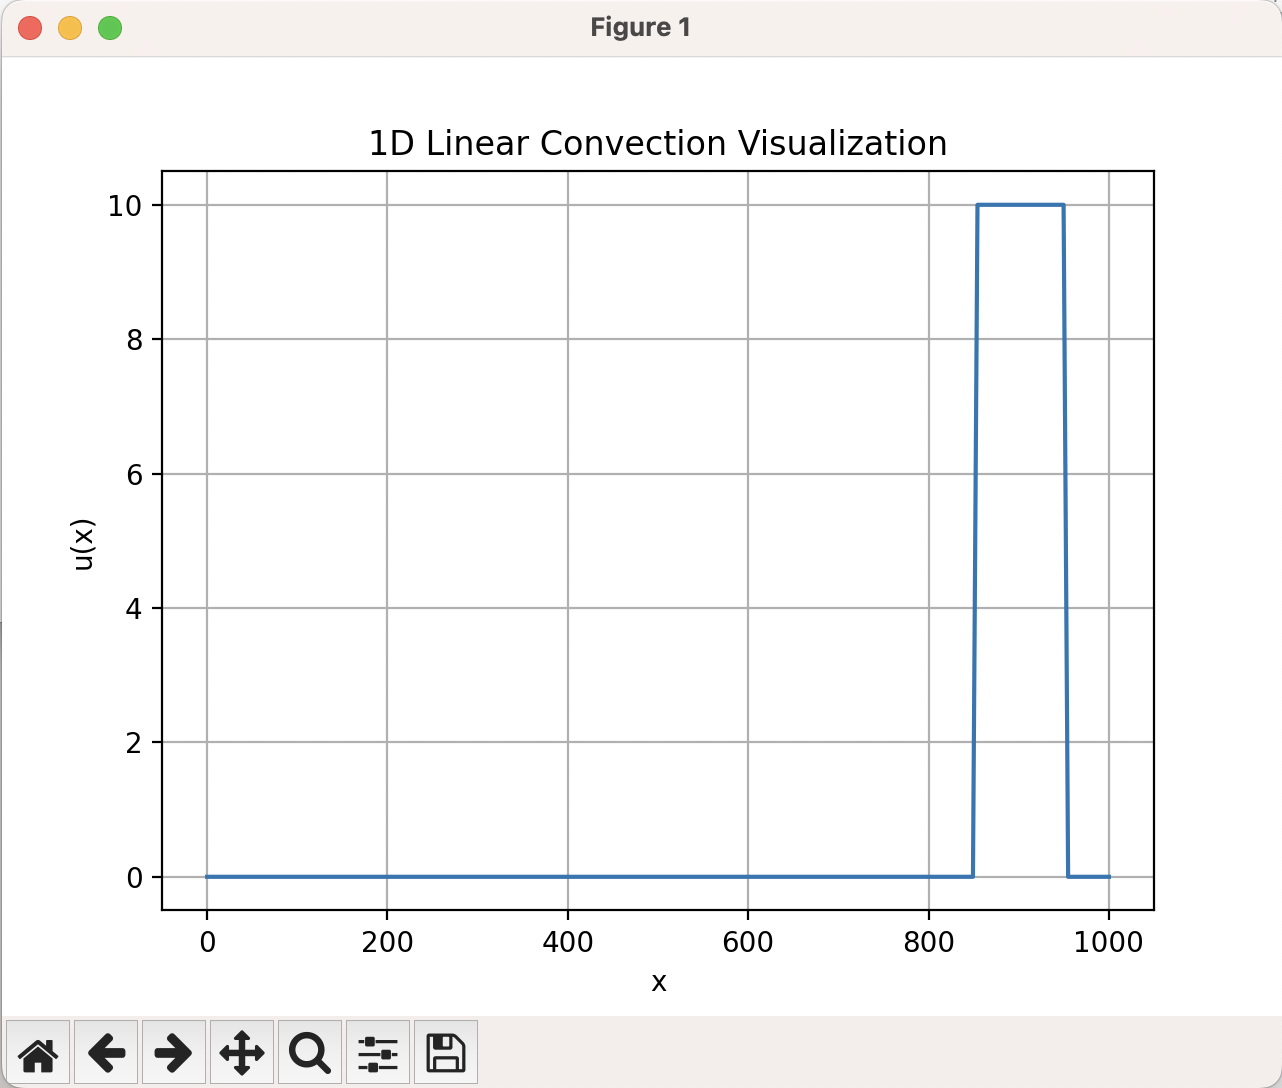